In [3]:
# Basic Libraries
# make sure python version 3.8 and above

!pip install gradio
!pip install snscrape
!pip install tensorflow-text
!pip install langdetect

  Using cached gradio-3.9-py3-none-any.whl (11.6 MB)
  Using cached python-multipart-0.0.5.tar.gz (32 kB)
  Preparing metadata (setup.py) ... done
  Using cached paramiko-2.12.0-py2.py3-none-any.whl (213 kB)
  Using cached h11-0.12.0-py3-none-any.whl (54 kB)
  Using cached pycryptodome-3.15.0-cp35-abi3-manylinux2010_x86_64.whl (2.3 MB)
  Using cached ffmpy-0.3.0.tar.gz (4.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached httpx-0.23.0-py3-none-any.whl (84 kB)
  Using cached httpcore-0.15.0-py3-none-any.whl (68 kB)
  Using cached rfc3986-1.5.0-py2.py3-none-any.whl (31 kB)
  Using cached linkify_it_py-1.0.3-py3-none-any.whl (19 kB)
  Using cached PyNaCl-1.5.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (856 kB)
  Using cached bcrypt-4.0.1-cp36-abi3-manylinux_2_28_x86_64.whl (593 kB)
  Using cached uc_micro_py-1.0.1-py3-none-any.whl (6.2 kB)
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=bbf5b5c418db62239ec22

In [4]:
import snscrape.modules.twitter as sntwitter
import numpy as np
import pandas as pd
import os
import pickle
import gradio as gr
import regex as re
import string
from time import time

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# bert
import tensorflow as tf
import tensorflow_text as text

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2022-11-06 00:56:18.222942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 00:56:18.399341: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 00:56:19.500764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local

# Sraping
- Take search keywords and number of entries
- Return list of strings

In [5]:
#Scrapper for the top games
def scraping_game(start, end, game, amount):
    tweets_df = {}
    
    # Creating list to append tweet data to
    tweets_list = []

    try:
        # Using TwitterSearchScraper to scrape data and append tweets to list
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper('%s lang:en since:%s until:%s' %(game,start,end)).get_items()):
            if i>(amount-1):
                break

            tweets_list.append([game, tweet.date, tweet.id, tweet.content, tweet.retweetCount, tweet.likeCount, tweet.user.username])

    except Exception:
        print(Exception)

    # Creating a dataframe from the tweets list above
    tweets_df[game] = pd.DataFrame(tweets_list, columns=['Game','Datetime', 'TweetId', 'Text', 'RetweetCount', 'LikeCount','Username'])
    print("Finish Scraping %s for %s" %(len(tweets_df[game]), game))
    
    #Concat dict df into one df
    # print(tweets_df)
    new_df = pd.concat(tweets_df.values(), ignore_index=True)
    return new_df['Text']

# Helpers
- Timer
- Sentiment Analyzer
- Map Labels

In [6]:
def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        arr1, arr2 = func(*args, **kwargs)
        t2 = time()
        print(f'{func.__name__!r} executed in {(t2-t1):.4f}s')
        return arr1, arr2, (t2-t1)
    return wrap_func

In [7]:
#function for analyzing overall sentiment
def analyze_sentiment(results, neg_hint:str, pos_hint:str):
    sentiment = np.mean(results)
    if sentiment < 0.25:
        overall_sentiment = f"very {neg_hint}"
    elif sentiment < 0.5:
        overall_sentiment = f"{neg_hint}"
    elif sentiment < 0.75:
        overall_sentiment = f"{pos_hint}"
    else:
        overall_sentiment = f"very {pos_hint}"
    return f"""{pos_hint} tweets = {int(np.sum(results))}, total tweets = {len(results)}
    average score = {sentiment:.4}, generally {overall_sentiment}"""

In [8]:
def sentiment_map(results, neg_hint:str, pos_hint:str):
    hints = []
    for result in results:
        if result == 0:
            hints.append(neg_hint)
        else:
            hints.append(pos_hint)
    return hints

# Model
- Reloading Model
- Preprocessing Inputs: stop after stopwords removal (no stemming/lemmatizing)
    - We observe from model training that stemmed/lemmatized text doesn't give SVM models significant better results.So here we are just using cleaned texts
- Give predictions

In [9]:
# reload model
BERT_SUB = tf.saved_model.load('bert_subjectivity_model')
BERT_POLAR = tf.saved_model.load('bert_polarity_model')
SVM_SUB = pickle.load(open('svm_subjectivity_model.sav', 'rb'))
SVM_POLAR = pickle.load(open('svm_polarity_model.sav', 'rb'))

2022-11-06 00:56:37.328000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 00:56:37.438247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 00:56:37.439172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 00:56:37.440372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
@timer_func
def bert_predict(cleaned_text:list):
    result_bert_sub = BERT_SUB(cleaned_text)
    result_bert_polar = BERT_POLAR(cleaned_text)
    return np.round(np.array(tf.sigmoid(result_bert_sub))[:,0]), np.round(np.array(tf.sigmoid(result_bert_polar))[:,0])

@timer_func
def svm_predict(cleaned_text:list):
    cv = CountVectorizer(ngram_range=(1,2), max_features=500).fit_transform(cleaned_text)
    tfidf_texts = TfidfTransformer(use_idf=True).fit_transform(cv)
    result_svm_sub = SVM_SUB.predict(tfidf_texts)
    result_svm_polar = SVM_POLAR.predict(tfidf_texts)
    return result_svm_sub, result_svm_polar

In [11]:
# set seed
DetectorFactory.seed = 0
nltk.download('stopwords')
nltk.download('punkt')

stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang


def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet


def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words


def pre_process(tweet):
    if language_detection(tweet) != 'en':
        return None         # suggesting not english language and cannot give predictions
    return remove_stopwords(remove_punc(decontracted(clean_text(tweet))))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Main Function

In [12]:
# Main NLP program
def nlp(game_title, scrap_no, activate_scrape, algorithm_choice):
    
    results = {}
    scrapped_tweets_raw = scraping_game("2022-01-01", "2022-11-04", game_title, scrap_no)
    #insert preprocessing function here
    print("Preprocessing texts now...")
    preprocessing_result = [pre_process(text) for text in scrapped_tweets_raw]
    cleaned_text, original_text = [],[]
    for i in range(len(scrapped_tweets_raw)):
        if preprocessing_result[i] and len(preprocessing_result[i].split())>1:
            cleaned_text.append(preprocessing_result[i])
            original_text.append(scrapped_tweets_raw[i])
    results['Original Text'] = original_text
    results['Cleaned Text'] = cleaned_text
    
    #Check which models to run 
    #NOTE INSERT PREDICTOR MODEL AS LABELED
    if 'Bert' in algorithm_choice:
        print("Running Bert now...")
        #Insert Bert model predictor here
        result_bert_sub, result_bert_polar, bert_exe_time = bert_predict(cleaned_text) # return individual results
        results['Bert Subjectivity'] = sentiment_map(result_bert_sub, 'neutral', 'subjective')
        results['Bert Polarity'] = sentiment_map(result_bert_polar,'negative', 'positive')
        
        bert_sentiment_result = analyze_sentiment(result_bert_sub, 'neutral', 'subjective')
        bert_polarity_result = analyze_sentiment(result_bert_polar, 'negative', 'positive')
        
    else:
        bert_sentiment_result, bert_polarity_result = "Bert model not being run","Bert model not being run"
    
    
    #Repeat for SVM model
    if 'SVM' in algorithm_choice:
        print("Running SVM now...")
        #Insert SVM model predictor here
        result_svm_sub, result_svm_polar, svm_exe_time = svm_predict(cleaned_text)
        results['SVM Subjectivity'] = sentiment_map(result_svm_sub, 'neutral', 'subjective')
        results['SVM Polarity'] = sentiment_map(result_svm_polar,'negative', 'positive')
        
        SVM_sentiment_result = analyze_sentiment(result_svm_sub, 'neutral', 'subjective')
        SVM_polarity_result = analyze_sentiment(result_svm_polar, 'negative', 'positive')
    else:
        SVM_sentiment_result, SVM_polarity_result = "SVM model not being run","SVM model not being run"
        
    print("Returning message")
    #if scrape checkbox is marked
    if activate_scrape:
        return {bert_sentiment : bert_sentiment_result,
                bert_polarity : bert_polarity_result,
                svm_sentiment : SVM_sentiment_result,
                svm_polarity : SVM_polarity_result, 
                scraped_tweets: pd.DataFrame(results)}
    else:
        return {bert_sentiment : game_title + " " + bert_sentiment_result,
                bert_polarity : bert_polarity_result,
                svm_sentiment : SVM_sentiment_result,
                svm_polarity : SVM_polarity_result}

##EDIT TO INCLUDE EXCEPTION

# Gradio Frontend code

In [14]:
with gr.Blocks() as demo:
    with gr.Row():
        #First Column
        with gr.Column(scale=1):
            game_title = gr.Textbox(label = "Game Title")
            
            #amount of tweets to scrape
            scrap_no = gr.Slider(200,1000, label = "Amount of tweets to scrape") #SVM requires more thajn 500 features
            
            #Choose to display scraped text
            activate_scrape = gr.Checkbox(label = "Show scraped data?")
            
            #Choice of algorithm
            algorithm_choice = gr.CheckboxGroup(choices = ["Bert", "SVM"]),
            
            submit_button = gr.Button("Submit")
            
        #Second Column displays all model results
        with gr.Column(scale=4):
            bert_sentiment = gr.Textbox(label = "Bert Subjectivity")
            bert_polarity = gr.Textbox(label = "Bert Polarity")
            svm_sentiment = gr.Textbox(label = "SVM Subjectivity")
            svm_polarity = gr.Textbox(label = "SVM Polarity")
            
    with gr.Row():       
        #Displays scrapped tweets if option is selected
        scraped_tweets = gr.DataFrame(label = "Scraped Data", headers=['Cleaned Text',
                                               'Bert Subjectivity',
                                               'Bert Polarity',
                                               'SVM Subjectivity',
                                               'SVM Polarity'], wrap=True)
    #Button to run nlp function
    submit_button.click(nlp, 
                        inputs=[game_title,scrap_no,activate_scrape,algorithm_choice[0]], 
                        outputs=[bert_sentiment,
                                 bert_polarity,
                                 svm_sentiment,
                                 svm_polarity,
                                 scraped_tweets]
                       )

demo.launch()

# Performance Testing

In [26]:
raw_testing_tweets =  pd.read_csv('../input/cz4045tweets/compiled_tweets.csv', encoding='latin')
raw_testing_tweets = raw_testing_tweets[raw_testing_tweets['Subjectivity'].isna()].sample(2000, random_state=42)

In [28]:
cleaned_testing_tweets = list(raw_testing_tweets['Text'].apply(pre_process))
cleaned_testing_tweets = [text for text in cleaned_testing_tweets if text and len(text.split())>1]

In [30]:
cleaned_testing_tweets[:10]

['absolutely amazing loving apexlegends content imragmf checked definitely keep man carbong group respawnstudios co butcudvong ',
 'cyberpunkgame welcome preem hotel outside night city co ueecpmhbfr ',
 'free gta modded accounts like amp follow win ps xbox one pc gta gtaonline ',
 'cyberpunkgame got intel friend friend right looking v ult beyondfast co mmmpznh ',
 'bruh excuse pc apex apexlegends co pcw jgn ',
 'know could get many points ranked like apexlegends xboxshare co ii dbguxmj ',
 'tf solarlight meanwhile youtube seeing video new team fortress glitch discovered gone wild ',
 'read lost ark bot situation know bad sucks thing game heavy real money purchases done banning buyers perma good start sure big lost ark handle ',
 'erichvela cyberpunkgame got question choom place one im sure get mean ',
 'apex legends might possibly worst game time sbmm public matches lack ammo health kills bad guns bad loot distribution unfair characters could go forever man ']

In [32]:
x = []
bert_time = []
svm_time =[]
for i in range(100,2000,50):
    print(f"========== {i} tweets ==========")
    txt = cleaned_testing_tweets[:i]
    result_bert_sub, result_bert_polar, bert_exe_time = bert_predict(txt) # return individual results
    result_svm_sub, result_svm_polar, svm_exe_time = svm_predict(txt)
    x.append(i)
    bert_time.append(bert_exe_time)
    svm_time.append(svm_exe_time)

========== 100 tweets ==========
'bert_predict' executed in 0.9175s
'svm_predict' executed in 0.1043s
========== 150 tweets ==========
'bert_predict' executed in 2.6079s
'svm_predict' executed in 0.2045s
========== 200 tweets ==========
'bert_predict' executed in 2.8941s
'svm_predict' executed in 0.2161s
========== 250 tweets ==========
'bert_predict' executed in 4.9526s
'svm_predict' executed in 0.2626s
========== 300 tweets ==========
'bert_predict' executed in 6.9070s
'svm_predict' executed in 0.3095s
========== 350 tweets ==========
'bert_predict' executed in 9.0056s
'svm_predict' executed in 0.3596s
========== 400 tweets ==========
'bert_predict' executed in 10.3760s
'svm_predict' executed in 0.4133s
========== 450 tweets ==========
'bert_predict' executed in 14.1854s
'svm_predict' executed in 0.4658s
========== 500 tweets ==========
'bert_predict' executed in 15.7501s
'svm_predict' executed in 0.5145s
========== 550 tweets ==========
'bert_predict' executed in 19.4727s
'svm_predi

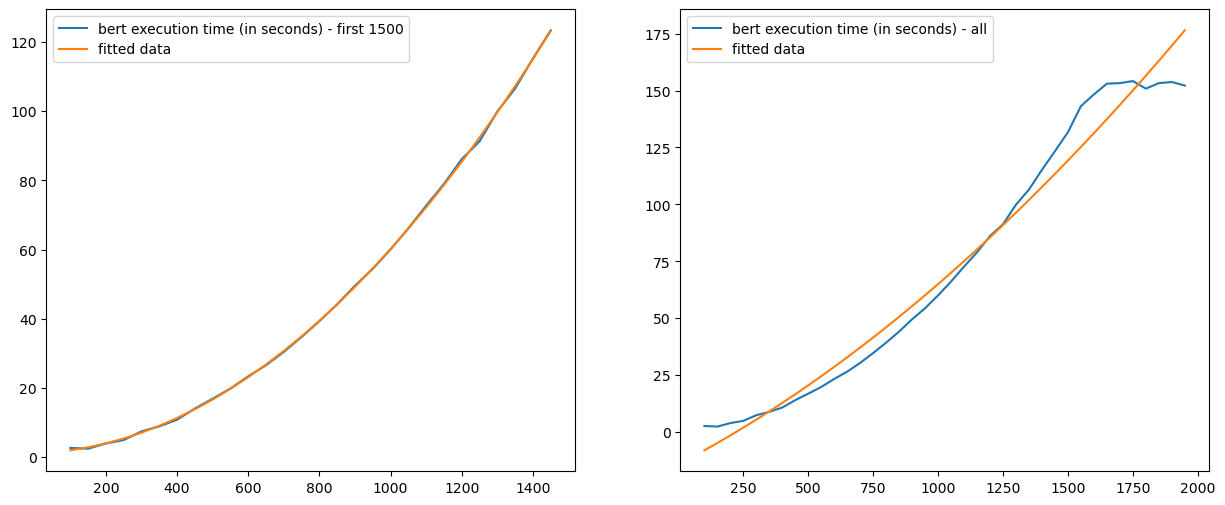

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15,6))

x_1500 = x[:28].copy()
bert_time_1500 = bert_time[:28].copy()
poly_1500 = np.polyfit(x_1500, bert_time_1500, deg=2)
ax[0].plot(x_1500, bert_time_1500, label='bert execution time (in seconds) - first 1500')
ax[0].plot(x_1500, np.polyval(poly_1500, x_1500), label='fitted data')
ax[0].legend()


poly = np.polyfit(x, bert_time, deg=2)

ax[1].plot(x, bert_time, label='bert execution time (in seconds) - all')
ax[1].plot(x, np.polyval(poly, x), label='fitted data')
ax[1].legend()

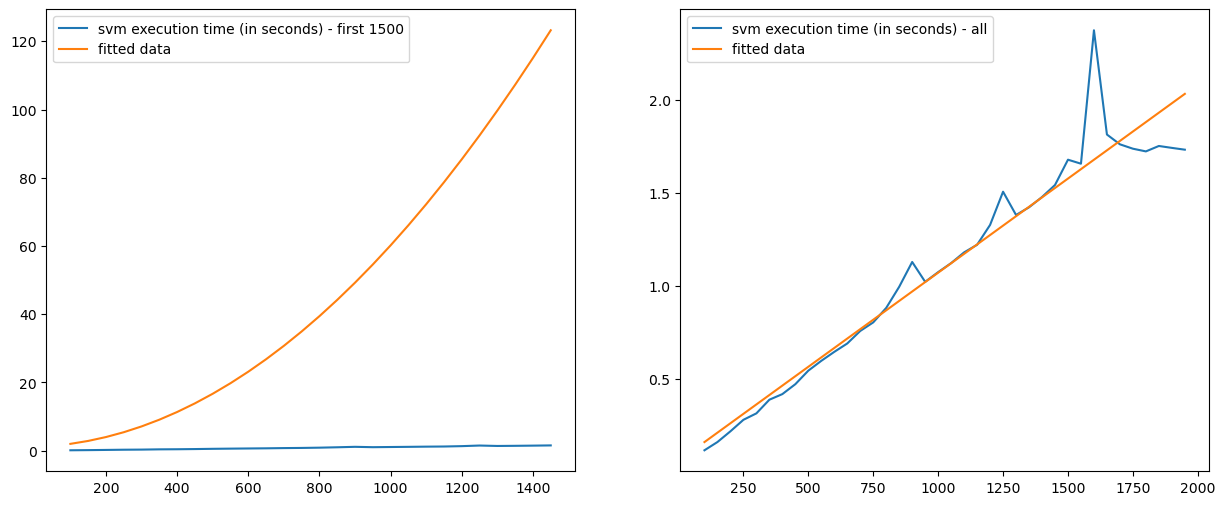

In [5]:
# print original performance
fig, ax = plt.subplots(1, 2, figsize=(15,6))

x_1500 = x[:28].copy()
svm_time_1500 = svm_time[:28].copy()
poly = np.polyfit(x, svm_time, deg=1)
ax[0].plot(x_1500, svm_time_1500, label='svm execution time (in seconds) - first 1500')
ax[0].plot(x_1500, np.polyval(poly_1500, x_1500), label='fitted data')
ax[0].legend()


poly = np.polyfit(x, svm_time, deg=1)

ax[1].plot(x, svm_time, label='svm execution time (in seconds) - all')
ax[1].plot(x, np.polyval(poly, x), label='fitted data')
ax[1].legend()